## **CPM Analysis with Abnormality Notification System**

In [0]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [0]:
import os
os.chdir('/content/mydrive/My Drive/')

**Importing Directories**

In [0]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from pylab import rcParams
from fbprophet import Prophet
import statsmodels.api as sm
import itertools
import pandas as pd
import numpy as np
import dateutil

**Installing necessary  directories**

In [0]:
!pip install slacker

**Importing Dataset**

In [0]:
CPM_data ='daily_revenue.csv'

import pandas as pd
import numpy as np
import dateutil


#from pandas import DataFrame as df

daily_revenue_df=pd.read_csv(CPM_data)
daily_revenue_df.columns=map(str.upper,daily_revenue_df.columns)
daily_revenue_df.head()

,DATE,SITE,REVENUE,PAGEVIEWS
0,7/13/2016,wearewearside,0.539353,389
1,7/13/2016,projectspurs,3.588072,2353
2,7/13/2016,totalbarca,5.130714,1228
3,7/14/2016,projectspurs,4.264064,2762
4,7/14/2016,totalbarca,2.280724,539


In [0]:
#Converting given dates to date type format

daily_revenue_df['DATE_FORMATTED'] = pd.to_datetime(daily_revenue_df['DATE'])
daily_revenue_df.head()

,DATE,SITE,REVENUE,PAGEVIEWS,DATE_FORMATTED
0,7/13/2016,wearewearside,0.539353,389,2016-07-13
1,7/13/2016,projectspurs,3.588072,2353,2016-07-13
2,7/13/2016,totalbarca,5.130714,1228,2016-07-13
3,7/14/2016,projectspurs,4.264064,2762,2016-07-14
4,7/14/2016,totalbarca,2.280724,539,2016-07-14


In [0]:
# getting start and end dates of the overall ads from dataset

print ("Start Date:", daily_revenue_df.DATE_FORMATTED.min())
print ("End Date:", daily_revenue_df.DATE_FORMATTED.max())

Start Date: 2016-07-13 00:00:00
End Date: 2017-05-31 00:00:00


In [0]:
#Imputing 0 for Revenue and Pageviews for the dates not present for a specific site 

df_f=daily_revenue_df.groupby('SITE').apply(
  lambda x: x.set_index('DATE_FORMATTED').asfreq('D')
).REVENUE.reset_index()


df_fg=daily_revenue_df.groupby('SITE').apply(
  lambda x: x.set_index('DATE_FORMATTED').asfreq('D')
).PAGEVIEWS.reset_index()

In [0]:
# Merging intermediate datasets

df_merged = pd.merge(df_f, df_fg, how='inner', on=['SITE','DATE_FORMATTED'])
df_merged['REVENUE'].fillna(0, inplace=True)
df_merged['PAGEVIEWS'].fillna(0, inplace=True)
df_merged.head()

,SITE,DATE_FORMATTED,REVENUE,PAGEVIEWS
0,1899.me,2017-03-15,0.000375,14.0
1,1899.me,2017-03-16,0.000249,19.0
2,1899.me,2017-03-17,0.000000,0.0
3,1899.me,2017-03-18,0.000412,17.0
4,1899.me,2017-03-19,0.000000,0.0


## CPM Calculation
CPM (cost per mille) is the amount of revenue we receive per 1000 impressions of an ad.

In [0]:
df_merged['CPM'] = (df_merged['REVENUE']*df_merged['PAGEVIEWS'])/1000
df_merged.head(10)

,SITE,DATE_FORMATTED,REVENUE,PAGEVIEWS,CPM
0,1899.me,2017-03-15,0.000375,14.0,0.000005
1,1899.me,2017-03-16,0.000249,19.0,0.000005
2,1899.me,2017-03-17,0.000000,0.0,0.000000
3,1899.me,2017-03-18,0.000412,17.0,0.000007
4,1899.me,2017-03-19,0.000000,0.0,0.000000
5,1899.me,2017-03-20,0.000666,12.0,0.000008
6,1899.me,2017-03-21,0.000000,0.0,0.000000
7,1899.me,2017-03-22,0.000000,0.0,0.000000
8,1899.me,2017-03-23,0.000000,0.0,0.000000
9,1899.me,2017-03-24,0.000900,13.0,0.000012


In [0]:
# CPM Revenue and Page views of each site for all dates 

df_mer = df_merged.groupby(['SITE', 'DATE_FORMATTED'])['REVENUE','PAGEVIEWS','CPM'].sum()
df_mer.head()

REVENUE  PAGEVIEWS       CPM
SITE    DATE_FORMATTED                               
1899.me 2017-03-15      0.000375       14.0  0.000005
        2017-03-16      0.000249       19.0  0.000005
        2017-03-17      0.000000        0.0  0.000000
        2017-03-18      0.000412       17.0  0.000007
        2017-03-19      0.000000        0.0  0.000000

In [0]:
# Total CPM per site

df =df_merged.groupby(['SITE'])['CPM'].agg('sum').reset_index()
df.head()

,SITE,CPM
0,1899.me,0.000515
1,49erswebzone,170065.201430
2,TRUE,0.000009
3,allarsenal,52.782232
4,allhabs,37.576400


In [0]:
#getting top 15 CPM generating Sites 

final_df = df.sort_values(by=['CPM'], ascending=False)
df_final=final_df.head(15) 
df_final

,SITE,CPM
23,comcastsportsnet,1.449855e+07
162,wowhead,1.428735e+07
69,mobafire,1.252928e+07
172,zam-wowhead,7.762401e+06
58,lakersnation,5.995595e+06
74,ndnation,1.625005e+06
89,postdispatch,1.372159e+06
71,mynhltraderumors,1.038857e+06
51,huskermax,6.107378e+05
26,cyclonefanatic,4.952360e+05


In [0]:
# Subsetting data for top perfroming websites for furthur analysis

df_line =df_merged.loc[df_merged['SITE'].isin(['wrestlinginc','bluemoon-mcfc','autoweek','overwolf','snackmedia-bluemoon-mcfc',
                                                             'cyclonefanatic','huskermax','mynhltraderumors',
                                                             'comcastsportsnet','wowhead','mobafire',
                                                             'zam-wowhead','lakersnation','ndnation','postdispatch'])]
df_line.sort_values(by=['CPM'], ascending=False).head(5)

,SITE,DATE_FORMATTED,REVENUE,PAGEVIEWS,CPM
21040,zam-wowhead,2017-03-28,512.464913,2092570.0,1.072369e+06
20138,wowhead,2017-01-29,1468.985069,681082.0,1.000499e+06
20137,wowhead,2017-01-28,1468.067518,663709.0,9.743696e+05
20136,wowhead,2017-01-27,1177.076682,738139.0,8.688462e+05
21041,zam-wowhead,2017-03-29,360.047948,2306019.0,8.302774e+05


**Trend Analysis of top 15 CPM generating sites**


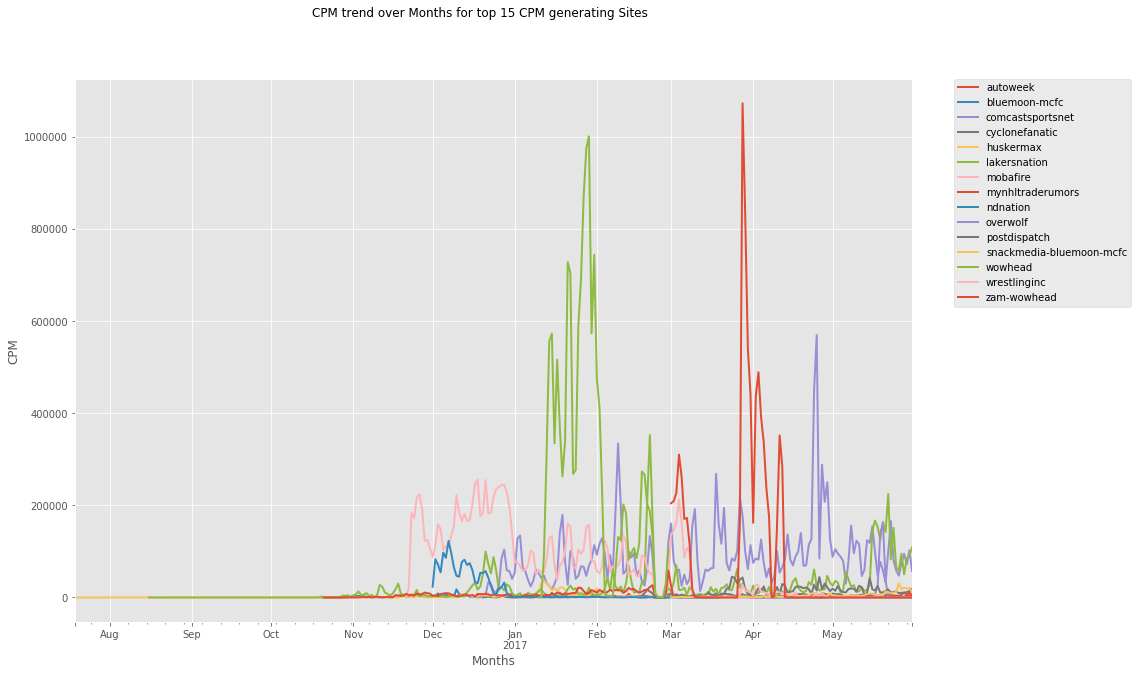

In [0]:
plt.style.use('ggplot')

rcParams['figure.figsize'] = 15, 10

df_line.pivot(index="DATE_FORMATTED", columns="SITE", values="CPM").plot(linewidth=2.0)
plt.suptitle('CPM trend over Months for top 15 CPM generating Sites')
plt.xlabel('Months')
plt.ylabel('CPM')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 10})
plt.show()

From the graph we can analyse that out of the 15 there are some sites which have too high values as compared to rest 

> Further plotting the peak CPM generating sites

In [0]:
df_line_t =df_line.loc[df_line['SITE'].isin(['mynhltraderumors','comcastsportsnet','wowhead','mobafire'])]
df_line_t.sort_values(by=['CPM'], ascending=False).head(10)

,SITE,DATE_FORMATTED,REVENUE,PAGEVIEWS,CPM
20138,wowhead,2017-01-29,1468.985069,681082.0,1.000499e+06
20137,wowhead,2017-01-28,1468.067518,663709.0,9.743696e+05
20136,wowhead,2017-01-27,1177.076682,738139.0,8.688462e+05
20140,wowhead,2017-01-31,1007.058989,738477.0,7.436899e+05
20130,wowhead,2017-01-21,1116.023856,651894.0,7.275293e+05
20131,wowhead,2017-01-22,1110.992528,633796.0,7.041426e+05
20135,wowhead,2017-01-26,1036.700710,665121.0,6.895314e+05
20134,wowhead,2017-01-25,966.993075,608808.0,5.887131e+05
20139,wowhead,2017-01-30,975.937028,587216.0,5.730858e+05
20124,wowhead,2017-01-15,995.413952,575302.0,5.726636e+05


In [0]:
df_line_t['SITE'].unique()

array(['comcastsportsnet', 'mobafire', 'mynhltraderumors', 'wowhead'],
      dtype=object)

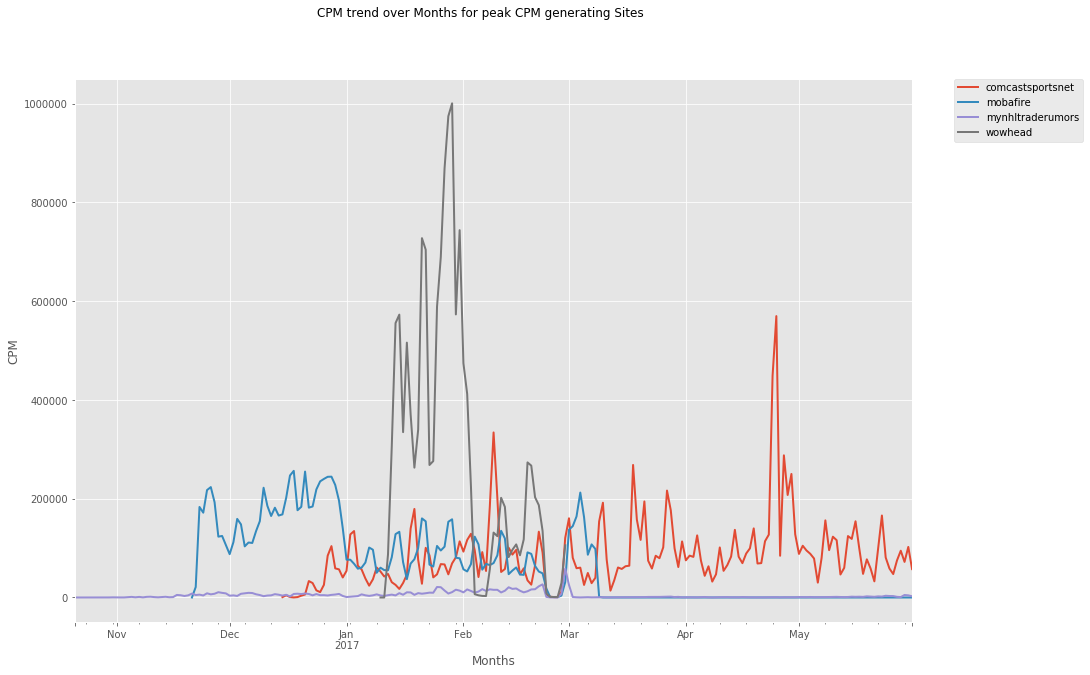

In [0]:
rcParams['figure.figsize'] = 15, 10

df_line_t.pivot(index="DATE_FORMATTED", columns="SITE", values="CPM").plot(linewidth=2.0)
plt.suptitle('CPM trend over Months for peak CPM generating Sites')
plt.xlabel('Months')
plt.ylabel('CPM')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 10})
plt.show()

From the graph we can notice that only 'comcastsportsnet' has CPM over the months while 'mobafire', 'mynhltraderumors', 'wowhead' they all have high CPM but have for comparatively shorter time span

## **Forecasting**

Forecasting next 6 months for 4 randonly selected websites showing different weekly and monthly trends and also seasonality 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


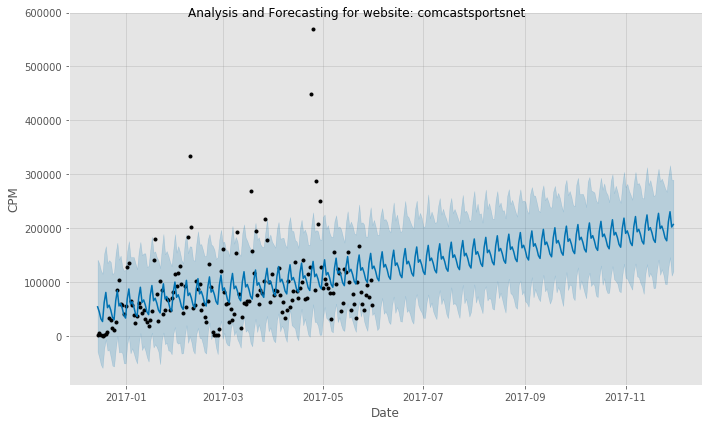

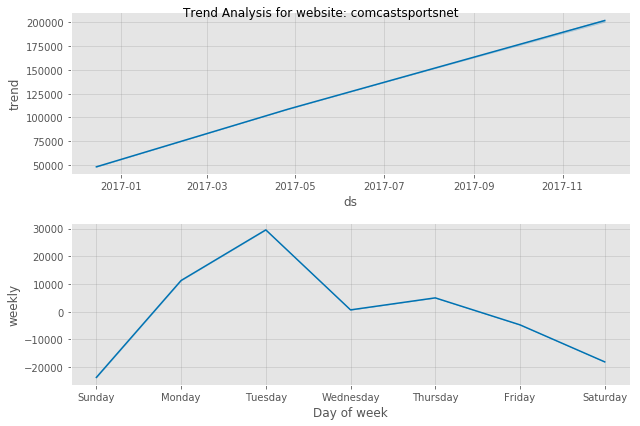

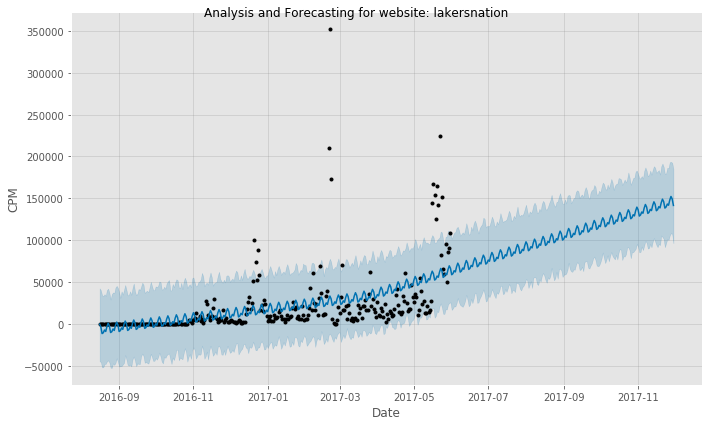

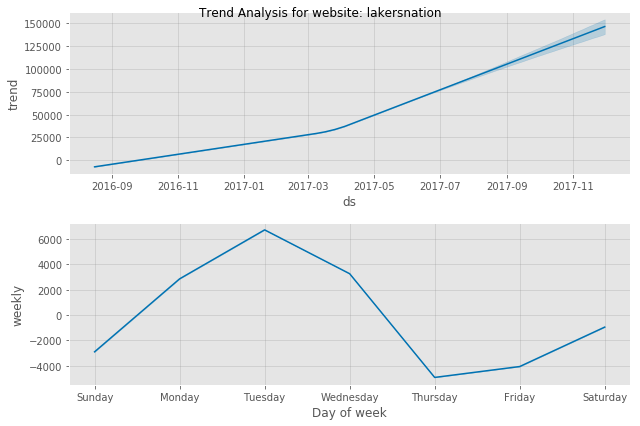

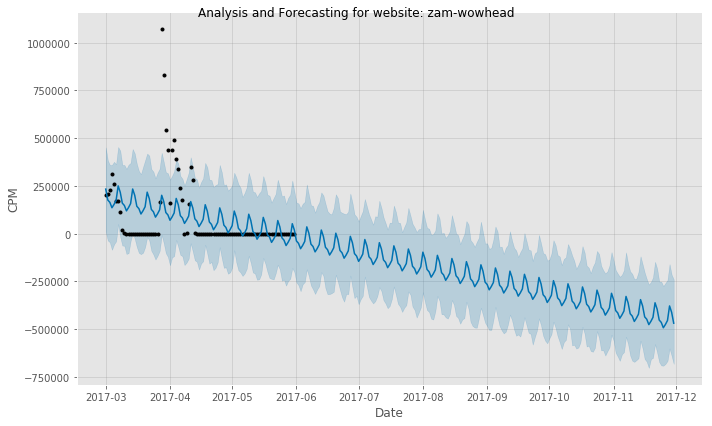

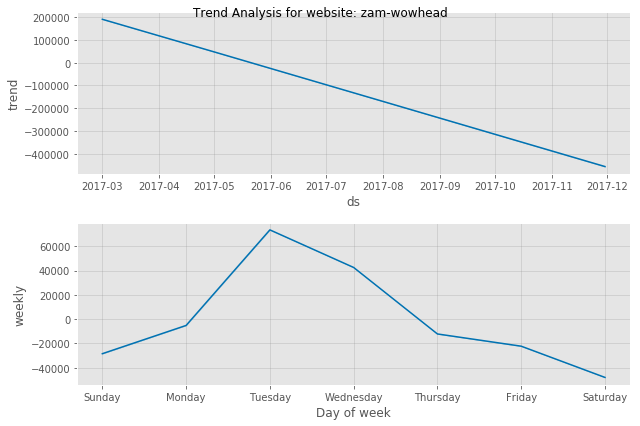

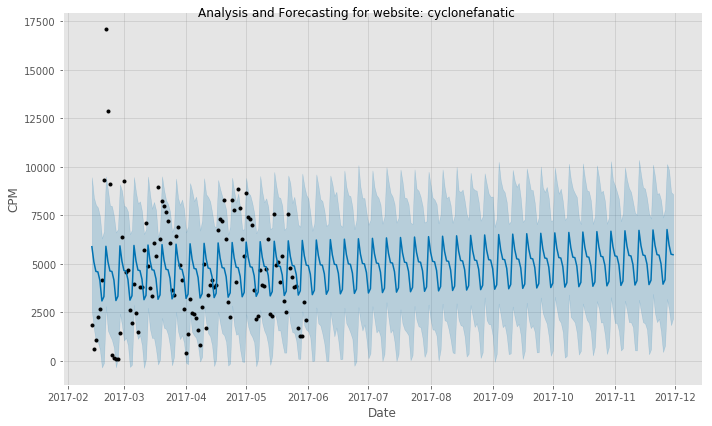

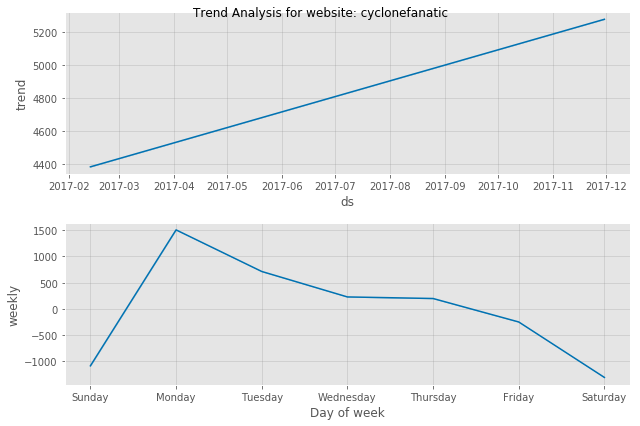

In [0]:
df_random_select= ['comcastsportsnet','lakersnation','zam-wowhead','cyclonefanatic']

from fbprophet import Prophet
for i in df_random_select:
  df_line =df_merged.loc[df_merged['SITE'] == i]
  df_line = df_line.rename(columns={'DATE_FORMATTED': 'ds', 'CPM': 'y'})

  m = Prophet()
  m.fit(df_line)

  future = m.make_future_dataframe(periods=183)    # periods = 183 which is 6 months forecasting
  future.tail()


  forecast = m.predict(future)
  forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
  
  message_fore = "Analysis and Forecasting for website: " + str(i)
  message_trend = "Trend Analysis for website: " + str(i)
  
  fig1 = m.plot(forecast, plot_cap= True, xlabel= 'Date', ylabel = 'CPM')
  fig1.suptitle(message_fore)

  fig2 = m.plot_components(forecast, plot_cap = True)
  fig2.suptitle(message_trend, fontweight=2)

## **Analysis on the Forecast and Trend graphs**

**For website : *comcastsportsnet * **

*   There is a upward trend over months
*   Many months from February to May of year 2017 have very high CPM for most of the days

>**Weekly Analysis**

*   Very Low or almost no CPM at the start of the week it gradually increases on Monday and Tuesdays are the period for high CPM 
*   CPM starts droping again from wednesday onwards and becomes almost close to 0 till the end of the week

**For website : *lakersnation * **

*   There is a slight curve but almost constant and flat trend over months
*   January March and May of year 2017 have many days with very high CPM

>**Weekly Analysis**

*   Very Low or almost no CPM at the start of the week it gradually increases on Monday and Tuesdays are the period for high CPM 
*   CPM again becomes low from wednesday and lowest on Thursday and again it increases from Friday

**For website : *zam-wowhead * **

*   There is a downward trend over months
*   Only some days of months "March and April have some CPM generated while other days have zero Revenue, Pageviews and CPM

>**Weekly Analysis**

*   Very Low or almost no CPM at the start of the week 
*   There are CPM on Monday and Tuesdays but then again no CPM on other days of the week

**For website : *cyclonefanatic * **

*   There is a upward trend over months
*   Only Month January of 2017 has some high CPM Value rest all the following months of year 2017 have normal CPM within forcasted confidence internval

>**Weekly Analysis**

*   Very Low or almost no CPM at the start of the week it gradually increases on Monday and have very high CPM 
*   CPM starts going down from tuesday and becomes almost close to 0 till the end of the week


## Overall Analysis


*   There are few days of the week with very High CPM which in turn indicated high Revenue and Pageviews
*   CPM is always 0 for weekends so there is a huge dip on Revenue and Pageview on weekends



Quantile Analysis of CPM of different websites

In [0]:
def q1(x):
    return x.quantile(0.25)

def q2(x):
    return x.quantile(0.75)

In [0]:
f = {'CPM': ['median', 'std', q1,q2,min, max]}

dff=pd.DataFrame(df_merged.groupby(['SITE']).agg(f).reset_index())
dff.dtypes
#print(dff.head(5))

com =dff.loc[dff['SITE'] == 'comcastsportsnet']
print(com)

                SITE           CPM                                            \
                            median           std            q1            q2   
23  comcastsportsnet  73311.112541  73342.563198  46691.404043  102782.13632   

                              
          min            max  
23  99.901526  569695.067955  


## **Data Preparation for Modelling**

Splitting the data into Train and Test datasets with a Split date of 2017-04-01

In [0]:
split_date = pd.datetime(2017,4,1)

print("Split Date:", split_date.date())
df_train = df_merged.loc[df_merged['DATE_FORMATTED'] <= split_date]
df_test = df_merged.loc[df_merged['DATE_FORMATTED'] > split_date]

Split Date: 2017-04-01


### Performing ARIMA Timeseries Modelling

> We are randomly selecting one web site and performing entire analysis on it
> ** Website :  comcastsportsnet **


In [0]:
df_com =df_merged.loc[df_merged['SITE'] == 'comcastsportsnet']
df_comc = df_com[['DATE_FORMATTED','CPM']]                  # Fetching only Date and CPM for a specific website
df = df_comc.set_index('DATE_FORMATTED')

df_com_t =df_test.loc[df_merged['SITE'] == 'comcastsportsnet']
df_comc_t = df_com_t[['DATE_FORMATTED','CPM']]                  # Fetching only Date and CPM for a specific website
df_t = df_comc_t.set_index('DATE_FORMATTED')

In [0]:
# converting datafram into Timeseries

ts = df['CPM']
ts.head(10)

ts_t = df_t['CPM']

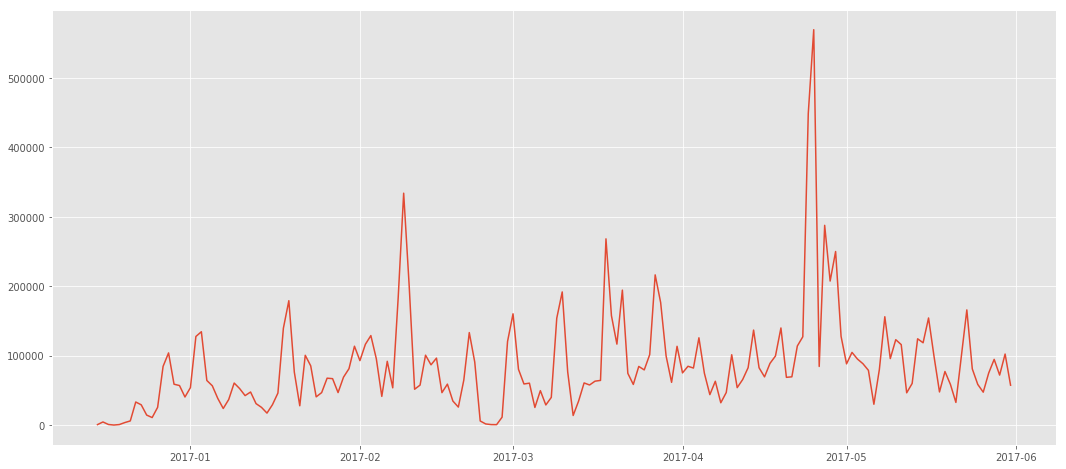

In [0]:
#Plotting CPM over time

plt.plot(ts)

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as CPM are low at the beginning of the each quarter (January, April July and October ) and high in the mid of quarters (like Feburary and March start in Quarter 1) 

** Decomposing our time series into three distinct components: **

*  Trend
*  Seasonality
*  Noise



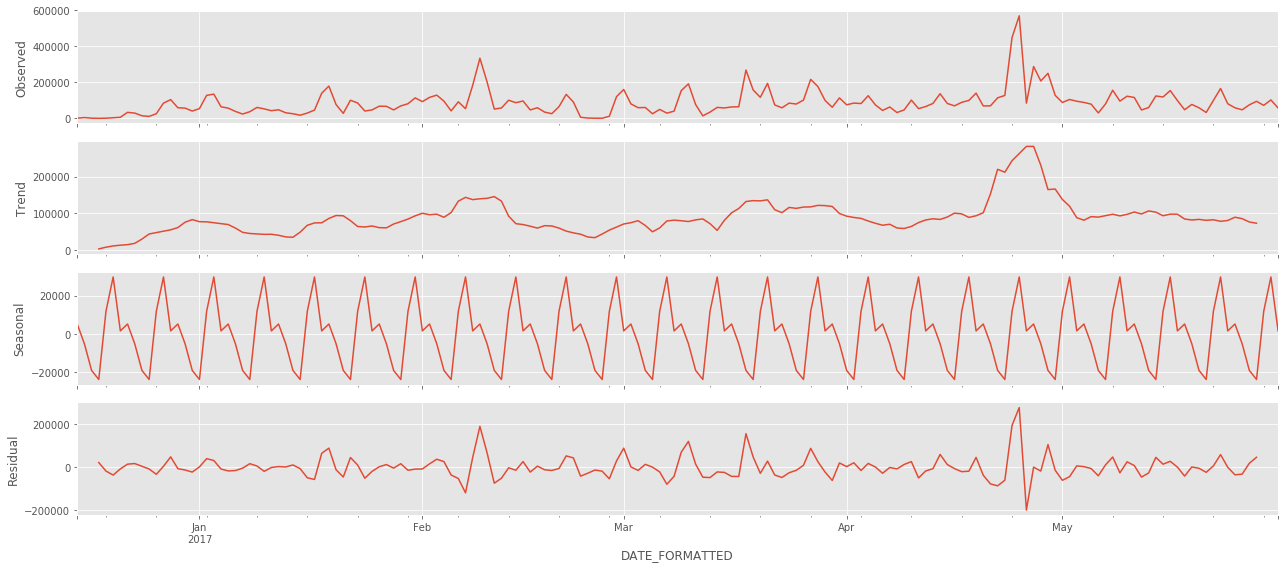

In [0]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts, model='additive')
fig = decomposition.plot()
plt.show()

The plots above explains how the CPM is unstable, along with its obvious seasonality.

##Time series forecasting with ARIMA

> Will handle the seasonility trend and noise issues in our data with this Model

In [0]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packa

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:4363.402347224337
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4033.4478889051506
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:4033.056838635145
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3665.3116992087143
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:4025.9824646615734
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3962.528923078975
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3715.676367256147
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3665.1791462424294


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4248.594394542611
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3941.2603069032375
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3965.6905529125006


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3606.795585010419
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3986.969274684582
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3920.972668045968


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3681.3351796079705


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3608.3450253052424
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:4179.350480572761
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3889.7101437957012
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:4006.0633410888795


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:3611.453437181407
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:3913.1764867990587
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:3883.0219361789987


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:3686.684054220551


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:3610.619101938356
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:4138.970252803147
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3847.76468215688
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:3966.772557463957


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:3587.3711815722036
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:3897.2387223819997


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3845.1789090942493
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:3681.1300768022566


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:3589.114316019695
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:4188.769355364506
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:3900.845088993259
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:3988.3914009062023


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:3623.0667071831413
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:3900.8451174358725
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:3902.052970540944


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:3652.500936618596


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:3624.9370407347096
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:4161.2195487675
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:3871.6802418483285
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:3963.929983128548


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:3598.04460476072
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:3896.6073130041277


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:3870.1807755387263
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:3653.887267215965


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:3599.7644171477546
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:4175.441091444294
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:3885.2599450851367
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:4001.7928559884713


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:3618.2949723670126
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:3885.489474053943
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:3878.1840400609694


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:3662.57515572408


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:3620.15224975878
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:4120.065699837023
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:3829.7471988121215


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:3942.7055045105903


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:3578.0818655682106
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:3854.0992440175423


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:3826.72108321468


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:3637.5214887280817


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:3579.8292138796123


The above output suggests that SARIMAX(1, 1, 1)x(0, 1, 1, 12) yields the lowest AIC value of 3578.08. Therefore we should consider this to be optimal option.

### Fitting the ARIMA Models

In [0]:
mod = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4681      0.133      3.522      0.000       0.208       0.729
ma.L1         -0.9407      0.120     -7.838      0.000      -1.176      -0.705
ma.S.L12      -1.0631      0.097    -10.915      0.000      -1.254      -0.872
sigma2      1.039e+10   5.91e-12   1.76e+21      0.000    1.04e+10    1.04e+10


Running Model Dignostics

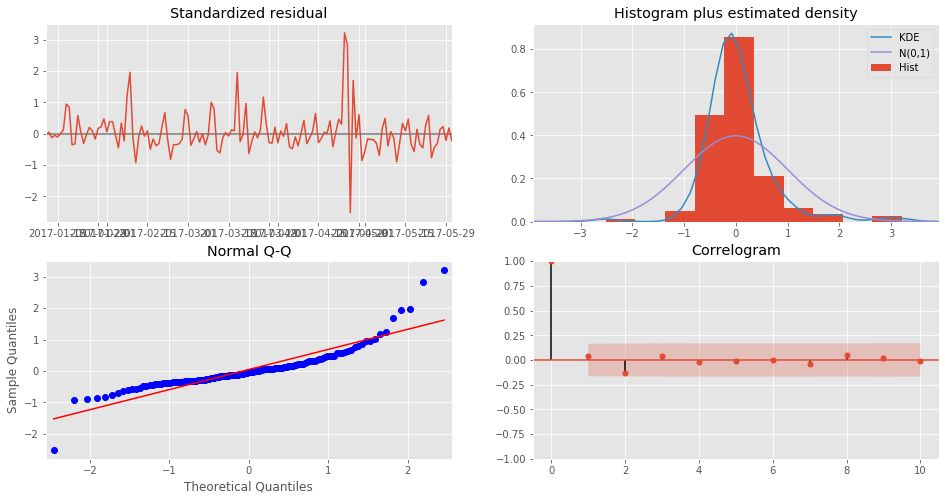

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating Forecast with Test Data 
> data after date 2017-04-01

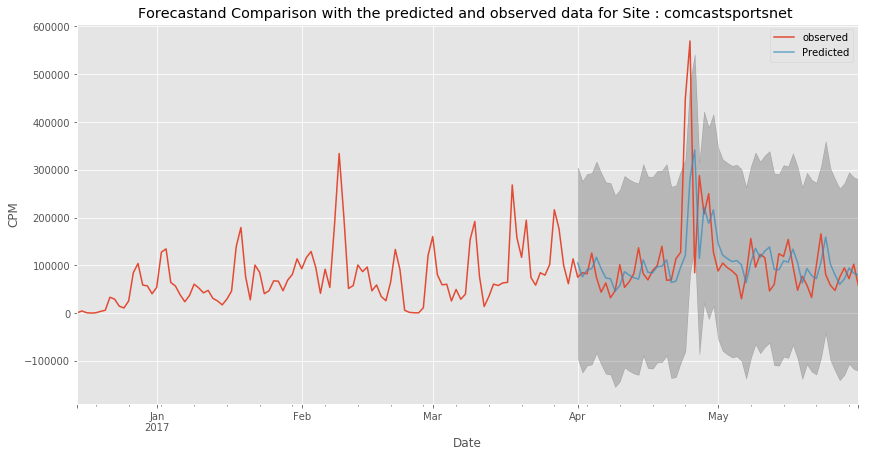

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = ts.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CPM')
title = 'Forecastand Comparison with the predicted and observed data for Site : comcastsportsnet '
plt.title(title)
plt.legend()
plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values pretty well, 

This graph shows a constant trend over the year but some trends changes at the start of quarters.

## Model Performance

In [0]:
y_forecasted = pred.predicted_mean
mse = ((y_forecasted - ts_t) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6219575089.12


In [0]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 78864.28


Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily CPM in the test set within 178864.28 of the CPM.

Our CPM range is  approx 100  to 569695, overall its a decent Model

## Notification of Anamolies

**Test Data**

In [0]:
t_data = df[df.index >= '2017-4-01' ].copy()
t_data.head()

,CPM
DATE_FORMATTED,
2017-04-01,75219.227012
2017-04-02,84754.027896
2017-04-03,82203.049340
2017-04-04,125780.746673
2017-04-05,74718.995436


In [0]:
# mapping confidence intervals

pred_ci_c = pred_ci.copy()
pred_ci_c['lower CPM'][pred_ci_c['lower CPM'] < 0] = 0

Since the confidence interval captures the 5% upeer and lower intervals its value can go below 0, which is invalid in our scenario the lowest CPM as per formula can only be 0

So, we are converting the negative values to 0

In [0]:
# Getting the Lower and upper bounds (from confidence intervals) and CPM (test dataset) together as a single data set 

df_stacked = pd.concat([pred_ci_c,t_data], axis = 1)
pred_ci_c['lower CPM'][df_stacked['lower CPM'] < 0] = 0
df_stacked.head()

,lower CPM,upper CPM,CPM
2017-04-01,0.0,305417.396757,75219.227012
2017-04-02,0.0,276424.623747,84754.027896
2017-04-03,0.0,291357.440792,82203.049340
2017-04-04,0.0,293426.597185,125780.746673
2017-04-05,0.0,317406.990768,74718.995436


Categorizing Normal, High and Low CPM 

In [0]:
df_stacked['Abnormality_Flag']= np.nan
df_stacked['Abnormality_Flag'][df_stacked['CPM'] < df_stacked['lower CPM']] = 'Abnormally Low'
df_stacked['Abnormality_Flag'][df_stacked['CPM'] > df_stacked['upper CPM']] = 'Abnormally High'
df_stacked['Abnormality_Flag'][(df_stacked['lower CPM'] < df_stacked['CPM']) & (df_stacked['CPM'] < df_stacked['upper CPM'])] = 'CPM within the Range'

group=df_stacked.groupby('Abnormality_Flag').count()

for idx, i in enumerate(group.index):
  print(i ,group.iloc[idx]['lower CPM'])

Abnormally High 2
Abnormally Low 1
CPM within the Range 58


In [0]:
import notify
notify.data(df_stacked)

The CPM was Abnormally High on 2017-04-24 00:00:00
The CPM was Abnormally High on 2017-04-25 00:00:00
The CPM was Abnormally Low on 2017-04-26 00:00:00


## Information


I have created below Python code for getting this notification using Slacker API, Slack is a online collaboration platform where : Announcements, updates, releases, and more can be shared, its a hub that brings the right people, information, and tools together to get work done.

With Slacker, everyone whose email id's are listed there will be getting a notification of abnormalities in the CPM of websites


**CODE**

import sys
import os
from slacker import Slacker

slack = Slacker('Slacker API address')   # **this is my  personal slacker API**

def data(dataframe):
    for idx, i in enumerate(dataframe.index):
      if dataframe.iloc[idx]['Abnormality_Flag'] != 'CPM within the Range':
    
          message = "The CPM was " + str(dataframe.iloc[idx]['Abnormality_Flag']) + " on " + str(i)    
          slack.chat.post_message("#timeseries-analysis", message)
          print(message)



## Abnormality Pattern detection on 2 randomly selected websites

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



For Website : comcastsportsnet


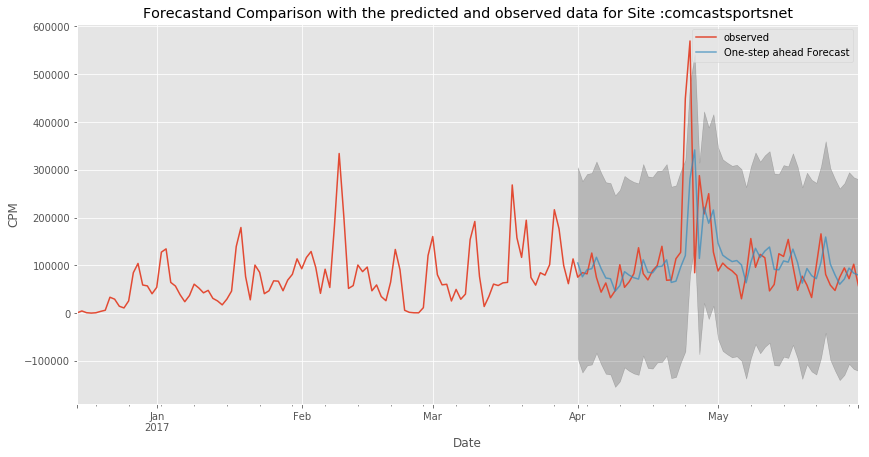

Abnormally High 2
Abnormally Low 1
CPM within the Range 58


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)



For Website : lakersnation


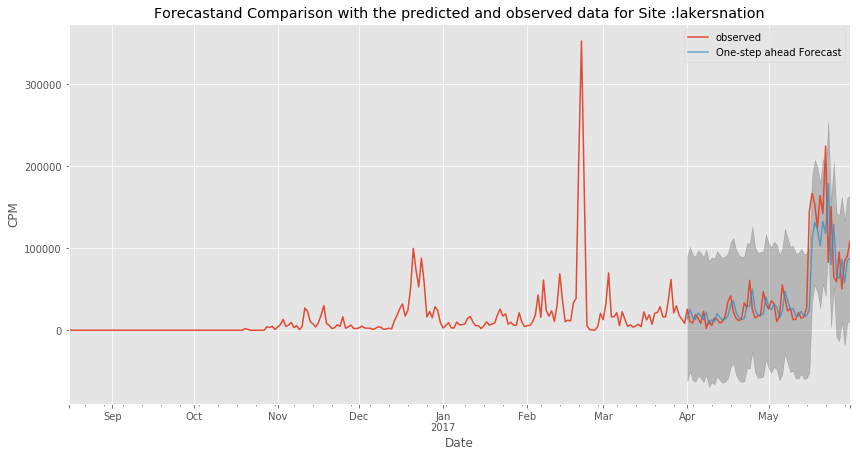

Abnormally High 19
Abnormally Low 2
CPM within the Range 40


In [0]:
#import notify_message
df_random= ['comcastsportsnet','lakersnation']
for i in df_random:
  df_com =df_merged.loc[df_merged['SITE'] == i]
  df_comc = df_com[['DATE_FORMATTED','CPM']]                  # Fetching only Date and CPM for a specific website
  df = df_comc.set_index('DATE_FORMATTED')

  df_com_t =df_test.loc[df_merged['SITE'] == i]
  df_comc_t = df_com_t[['DATE_FORMATTED','CPM']]                  # Fetching only Date and CPM for a specific website
  df_t = df_comc_t.set_index('DATE_FORMATTED')
  
  
  # converting dataframe into Timeseries

  ts = df['CPM']
  ts_t = df_t['CPM']
  
  mod = sm.tsa.statespace.SARIMAX(ts,order=(1, 1, 1),
                                  seasonal_order=(0, 1, 1, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
  results = mod.fit()
  print('\nFor Website :', i)
  pred = results.get_prediction(start=pd.to_datetime('2017-04-01'), dynamic=False)
  pred_ci = pred.conf_int()

  ax = ts.plot(label='observed')
  pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

  ax.fill_between(pred_ci.index,
                  pred_ci.iloc[:, 0],
                  pred_ci.iloc[:, 1], color='k', alpha=.2)

  ax.set_xlabel('Date')
  ax.set_ylabel('CPM')
  title = 'Forecastand Comparison with the predicted and observed data for Site :' +  str(i)
  plt.title(title)
  plt.legend()
  plt.show()
  
  
  # mapping confidence intervals

  pred_ci_c = pred_ci.copy()
  pred_ci_c['lower CPM'][pred_ci_c['lower CPM'] < 0] = 0
  
  # Getting the Lower and upper bounds (from confidence intervals) and CPM (test dataset) together as a single data set 

  df_stacked = pd.concat([pred_ci_c,t_data], axis = 1)
  pred_ci_c['lower CPM'][df_stacked['lower CPM'] < 0] = 0
  df_stacked.head()
  
  
  df_stacked['Abnormality_Flag']= np.nan
  df_stacked['Abnormality_Flag'][df_stacked['CPM'] < df_stacked['lower CPM']] = 'Abnormally Low'
  df_stacked['Abnormality_Flag'][df_stacked['CPM'] > df_stacked['upper CPM']] = 'Abnormally High'
  df_stacked['Abnormality_Flag'][(df_stacked['lower CPM'] < df_stacked['CPM']) & (df_stacked['CPM'] < df_stacked['upper CPM'])] = 'CPM within the Range'
  
  
  group=df_stacked.groupby('Abnormality_Flag').count()

  for idx, i in enumerate(group.index):
    print(i ,group.iloc[idx]['lower CPM'])
  
  
  #notify_message.data(df_stacked)

##Comparison between sites :

**Performed camparison between two sites comcastsportsnet and lakersnation based on their CPM value and abnormalities**

*  For CPM Value comcastsportsnet has almost double avg CPM than lakersnation over all the months
*  comcastsportsnet is pretty stable and do not produce too many Abnormalities, only 3 abnormalities were found out of all rest other was within the control range
*  lakersnation is unstable and was producing too many Abnormalities total of 21 abnormalities were found out of all rest other was within the control range but the Abnormalities produced was mostly on high CPM side which indicates the 
ads site were getting more page views and were generating more profits as compared to previous months or days

#Note

Similar to the above comparison for two websites , comparison for all the websites and their anamolies can be captured with the same code above.

I have used free slack account and because of too many slack messages I am getting http error, I wanted to avoid that so performed comparison using two random websites